In [1]:
# Paso 0: Importar librerias necesarias

import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import pylab as plt

In [2]:
# Paso 1: Importar el DF de todas las empresas del IBEX 35

df = pd.read_csv('ibex35.csv')

df.head()

,id,ticker,empresa,date,open,high,low,close,adj close,volume
0,1,ANA,Acciona,2019-01-02,73.900002,73.900002,73.900002,73.900002,64.148270,0
1,1,ANA,Acciona,2022-06-24,174.199997,178.800003,174.000000,178.800003,169.562302,0
2,1,ANA,Acciona,2022-06-23,169.899994,173.199997,169.000000,173.000000,164.061951,0
3,1,ANA,Acciona,2022-06-22,171.399994,171.399994,168.800003,170.199997,161.406616,0
4,1,ANA,Acciona,2022-06-21,179.699997,179.699997,172.300003,173.600006,164.630966,0


In [3]:
# Paso 2: Filtrar por la empresa sobre la que realizar el modelo

acciona = df[df['empresa'] == 'Acciona']

acciona.shape

(1316, 10)

In [4]:
# Paso 3: Seleccionar las columnas definitivas que utilizaremos

acciona = acciona [['date','open','high','low','close','adj close']]

acciona.shape

(1316, 6)

In [5]:
# Paso 4: Modificar el formato de columna 'date' (format: object ===> datatime)

acciona['date'] = pd.to_datetime(acciona['date'], format="%Y-%m-%d")

acciona.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1316 entries, 0 to 1315
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1316 non-null   datetime64[ns]
 1   open       1316 non-null   float64       
 2   high       1316 non-null   float64       
 3   low        1316 non-null   float64       
 4   close      1316 non-null   float64       
 5   adj close  1316 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 72.0 KB


In [6]:
# Paso 5: Ordenar el DF por fecha

acciona.sort_values(by='date',ascending= True, inplace=True)

acciona.head()

,date,open,high,low,close,adj close
0,2019-01-02,73.900002,73.900002,73.900002,73.900002,64.148270
541,2019-01-03,74.199997,74.199997,74.199997,74.199997,64.408676
879,2019-01-04,76.580002,76.580002,76.580002,76.580002,66.474617
878,2019-01-07,76.980003,77.139999,75.860001,77.139999,66.960716
877,2019-01-08,77.139999,78.400002,77.139999,78.239998,67.915558


In [7]:
# Paso 6: Filtrar nuevamente para eliminar efecto COVID del análisis (previo a 2021)

# Filtro:

fecha_inicio = '2021-01-01'
fecha_fin = '2024-03-01'

acciona = acciona[(acciona['date'] >= fecha_inicio) & (acciona['date'] <= fecha_fin)]

# Comprobar si se ha aplicado correctamente

acciona.shape

(811, 6)

In [8]:
# Paso 7: Añadir al DF fechas obviadas por mercado de valores español (fin de semana y festivos)

# Rango de fechas desde '2021-01-01' a '2024-03-01'

date_range = pd.date_range(start=acciona['date'].min(), end=acciona['date'].max(), freq='D')

# Reindexa el DF con el nuevo rango de fechas

acciona = acciona.set_index('date').reindex(date_range).reset_index()

# Volver a modificar el nombre de columna 'date'

acciona = acciona.rename(columns={'index': 'date'})

acciona = acciona.fillna(method='ffill')

In [9]:
# Paso 8: Transformar serie temporal en ramdon forest

acciona_rfr = acciona[['date','close']]

acciona_rfr

,date,close
0,2021-01-04,116.699997
1,2021-01-05,116.599998
2,2021-01-06,119.400002
3,2021-01-07,125.900002
4,2021-01-08,127.800003
...,...,...
1148,2024-02-26,101.550003
1149,2024-02-27,104.199997
1150,2024-02-28,100.300003
1151,2024-02-29,104.050003


In [10]:
acciona_rfr.close = acciona_rfr.close.round(2)

acciona_rfr

,date,close
0,2021-01-04,116.70
1,2021-01-05,116.60
2,2021-01-06,119.40
3,2021-01-07,125.90
4,2021-01-08,127.80
...,...,...
1148,2024-02-26,101.55
1149,2024-02-27,104.20
1150,2024-02-28,100.30
1151,2024-02-29,104.05


In [11]:
new_df = pd.DataFrame(columns=['d-4', 'd-3', 'd-2', 'd-1', 'do'])

new_df

,d-4,d-3,d-2,d-1,do


In [12]:
for i in range(len(new_df.columns)):
    new_df[new_df.columns[i]] = acciona_rfr['close'].shift(-i)

In [13]:
new_df

,d-4,d-3,d-2,d-1,do
0,116.70,116.60,119.40,125.90,127.8
1,116.60,119.40,125.90,127.80,127.8
2,119.40,125.90,127.80,127.80,127.8
3,125.90,127.80,127.80,127.80,124.7
4,127.80,127.80,127.80,124.70,124.8
...,...,...,...,...,...
1148,101.55,104.20,100.30,104.05,107.0
1149,104.20,100.30,104.05,107.00,NaN
1150,100.30,104.05,107.00,NaN,NaN
1151,104.05,107.00,NaN,NaN,NaN


In [14]:
new_df.dropna(axis=0,inplace=True)

In [15]:
new_df

,d-4,d-3,d-2,d-1,do
0,116.70,116.60,119.40,125.90,127.80
1,116.60,119.40,125.90,127.80,127.80
2,119.40,125.90,127.80,127.80,127.80
3,125.90,127.80,127.80,127.80,124.70
4,127.80,127.80,127.80,124.70,124.80
...,...,...,...,...,...
1144,106.70,104.75,104.75,104.75,101.55
1145,104.75,104.75,104.75,101.55,104.20
1146,104.75,104.75,101.55,104.20,100.30
1147,104.75,101.55,104.20,100.30,104.05


In [16]:
from sklearn.ensemble import RandomForestRegressor as RFR 

rfr=RFR()

In [17]:
# Paso : Separar X e y para los modelos

X = new_df.drop('do',axis=1)

y = new_df.do 

In [18]:
from sklearn.model_selection import train_test_split as tts   


X_train, X_test, y_train, y_test = tts(X, y,
                                       train_size=0.8,
                                       test_size=0.2,
                                       random_state=42
                                      )

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((919, 4), (230, 4), (919,), (230,))

In [19]:
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [20]:
rfr.predict(X_test)[:10]

array([127.027     , 184.729     , 192.407     , 140.982     ,
       184.456     , 136.5105    , 165.0475    , 143.7055    ,
       166.97872619, 157.2825    ])

In [21]:
from sklearn.metrics import mean_squared_error as mse  # error cuadratico medio


y_pred=rfr.predict(X_test)

mse(y_test, y_pred, squared=False)  # RMSE

2.999856033047835

In [22]:
%pip install lazypredict


Note: you may need to restart the kernel to use updated packages.


In [23]:
from lazypredict.Supervised import LazyRegressor

# Initialize Lazy Regressor
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
# Fit and score all models
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
print(models)

pd.options.display.max_rows=100

100%|██████████| 42/42 [00:02<00:00, 16.28it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1014
[LightGBM] [Info] Number of data points in the train set: 919, number of used features: 4
[LightGBM] [Info] Start training from score 154.575190
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
OrthogonalMatchingPursuit                    0.99       0.99   2.61   
HuberRegressor                               0.99       0.99   2.62   
LassoLarsIC                                  0.99       0.99   2.63   
LassoLarsCV                                  0.99       0.99   2.63   
LarsCV                                       0.99       0.99   2.63   
LassoCV                                      0.99       0.99   2.63   
Lars                                         0.99       0.99   2.63   
TransformedTargetReg

In [24]:
from sklearn.linear_model import OrthogonalMatchingPursuit as OMP

omp= OMP()


In [25]:
omp.fit(X_train, y_train)

OrthogonalMatchingPursuit()

In [26]:
omp.predict(X_test)[:10]

array([127.31452695, 184.0944055 , 196.66780567, 141.28497158,
       183.69524994, 137.9919382 , 164.83514968, 141.78391603,
       166.93071638, 157.25119402])

In [27]:
y_pred=omp.predict(X_test)

mse(y_test, y_pred, squared=False)  # RMSE

2.6131169237326555

In [28]:
new_df_1 = new_df[['d-4','d-3','d-2','d-1']]

new_df_1

,d-4,d-3,d-2,d-1
0,116.70,116.60,119.40,125.90
1,116.60,119.40,125.90,127.80
2,119.40,125.90,127.80,127.80
3,125.90,127.80,127.80,127.80
4,127.80,127.80,127.80,124.70
...,...,...,...,...
1144,106.70,104.75,104.75,104.75
1145,104.75,104.75,104.75,101.55
1146,104.75,104.75,101.55,104.20
1147,104.75,101.55,104.20,100.30


In [29]:
y_pred=omp.predict(new_df_1)

pred = pd.DataFrame(y_pred)

pred

,0
0,126.02
1,127.91
2,127.91
3,127.91
4,124.82
...,...
1144,104.91
1145,101.72
1146,104.36
1147,100.47


In [30]:
new_df['pred'] = pred

In [31]:
new_df

,d-4,d-3,d-2,d-1,do,pred
0,116.70,116.60,119.40,125.90,127.80,126.02
1,116.60,119.40,125.90,127.80,127.80,127.91
2,119.40,125.90,127.80,127.80,127.80,127.91
3,125.90,127.80,127.80,127.80,124.70,127.91
4,127.80,127.80,127.80,124.70,124.80,124.82
...,...,...,...,...,...,...
1144,106.70,104.75,104.75,104.75,101.55,104.91
1145,104.75,104.75,104.75,101.55,104.20,101.72
1146,104.75,104.75,101.55,104.20,100.30,104.36
1147,104.75,101.55,104.20,100.30,104.05,100.47


In [32]:
new_df.rename(columns={'do': 'real'}, inplace=True)



In [33]:
new_df['error'] = new_df.pred - new_df.real

new_df

,d-4,d-3,d-2,d-1,real,pred,error
0,116.70,116.60,119.40,125.90,127.80,126.02,-1.78
1,116.60,119.40,125.90,127.80,127.80,127.91,0.11
2,119.40,125.90,127.80,127.80,127.80,127.91,0.11
3,125.90,127.80,127.80,127.80,124.70,127.91,3.21
4,127.80,127.80,127.80,124.70,124.80,124.82,0.02
...,...,...,...,...,...,...,...
1144,106.70,104.75,104.75,104.75,101.55,104.91,3.36
1145,104.75,104.75,104.75,101.55,104.20,101.72,-2.48
1146,104.75,104.75,101.55,104.20,100.30,104.36,4.06
1147,104.75,101.55,104.20,100.30,104.05,100.47,-3.58


In [34]:
acciona_rfr

,date,close
0,2021-01-04,116.70
1,2021-01-05,116.60
2,2021-01-06,119.40
3,2021-01-07,125.90
4,2021-01-08,127.80
...,...,...
1148,2024-02-26,101.55
1149,2024-02-27,104.20
1150,2024-02-28,100.30
1151,2024-02-29,104.05


In [35]:
inicio_indice = 0
fin_indice = 1148
acciona_rfr = acciona_rfr.loc[inicio_indice:fin_indice]

In [36]:
acciona_rfr

,date,close
0,2021-01-04,116.70
1,2021-01-05,116.60
2,2021-01-06,119.40
3,2021-01-07,125.90
4,2021-01-08,127.80
...,...,...
1144,2024-02-22,106.70
1145,2024-02-23,104.75
1146,2024-02-24,104.75
1147,2024-02-25,104.75


In [37]:
new_df['date'] = acciona_rfr.date


In [38]:
new_df

,d-4,d-3,d-2,d-1,real,pred,error,date
0,116.70,116.60,119.40,125.90,127.80,126.02,-1.78,2021-01-04
1,116.60,119.40,125.90,127.80,127.80,127.91,0.11,2021-01-05
2,119.40,125.90,127.80,127.80,127.80,127.91,0.11,2021-01-06
3,125.90,127.80,127.80,127.80,124.70,127.91,3.21,2021-01-07
4,127.80,127.80,127.80,124.70,124.80,124.82,0.02,2021-01-08
...,...,...,...,...,...,...,...,...
1144,106.70,104.75,104.75,104.75,101.55,104.91,3.36,2024-02-22
1145,104.75,104.75,104.75,101.55,104.20,101.72,-2.48,2024-02-23
1146,104.75,104.75,101.55,104.20,100.30,104.36,4.06,2024-02-24
1147,104.75,101.55,104.20,100.30,104.05,100.47,-3.58,2024-02-25


In [39]:
new_df.insert(0, 'date', new_df.pop('date'))

In [40]:
new_df

,date,d-4,d-3,d-2,d-1,real,pred,error
0,2021-01-04,116.70,116.60,119.40,125.90,127.80,126.02,-1.78
1,2021-01-05,116.60,119.40,125.90,127.80,127.80,127.91,0.11
2,2021-01-06,119.40,125.90,127.80,127.80,127.80,127.91,0.11
3,2021-01-07,125.90,127.80,127.80,127.80,124.70,127.91,3.21
4,2021-01-08,127.80,127.80,127.80,124.70,124.80,124.82,0.02
...,...,...,...,...,...,...,...,...
1144,2024-02-22,106.70,104.75,104.75,104.75,101.55,104.91,3.36
1145,2024-02-23,104.75,104.75,104.75,101.55,104.20,101.72,-2.48
1146,2024-02-24,104.75,104.75,101.55,104.20,100.30,104.36,4.06
1147,2024-02-25,104.75,101.55,104.20,100.30,104.05,100.47,-3.58


In [46]:
import matplotlib.pyplot as plt

In [57]:
new_df.error = new_df.error.astype(int)

In [58]:
new_df

,date,d-4,d-3,d-2,d-1,real,pred,error
0,2021-01-04,116.70,116.60,119.40,125.90,127.80,126.02,-1
1,2021-01-05,116.60,119.40,125.90,127.80,127.80,127.91,0
2,2021-01-06,119.40,125.90,127.80,127.80,127.80,127.91,0
3,2021-01-07,125.90,127.80,127.80,127.80,124.70,127.91,3
4,2021-01-08,127.80,127.80,127.80,124.70,124.80,124.82,0
...,...,...,...,...,...,...,...,...
1144,2024-02-22,106.70,104.75,104.75,104.75,101.55,104.91,3
1145,2024-02-23,104.75,104.75,104.75,101.55,104.20,101.72,-2
1146,2024-02-24,104.75,104.75,101.55,104.20,100.30,104.36,4
1147,2024-02-25,104.75,101.55,104.20,100.30,104.05,100.47,-3


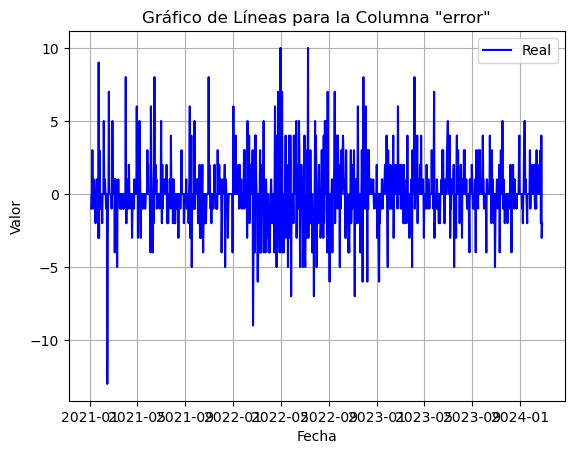

In [59]:
error_data = new_df['error']


# Crear un gráfico de líneas
plt.plot(new_df['date'], error_data, marker='None', linestyle='-', color='b', label='Real')

# Configuración del gráfico
plt.title('Gráfico de Líneas para la Columna "error"')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
condiciones = [
    (new_df['error'] == 0),
    (new_df['error'] >= 1),
    (new_df['error'] <= -1)
]

categorias = [0, 1, 2]

new_df['cate'] = np.select(condiciones, categorias, default=None)

In [61]:
new_df

,date,d-4,d-3,d-2,d-1,real,pred,error,cate
0,2021-01-04,116.70,116.60,119.40,125.90,127.80,126.02,-1,2
1,2021-01-05,116.60,119.40,125.90,127.80,127.80,127.91,0,0
2,2021-01-06,119.40,125.90,127.80,127.80,127.80,127.91,0,0
3,2021-01-07,125.90,127.80,127.80,127.80,124.70,127.91,3,1
4,2021-01-08,127.80,127.80,127.80,124.70,124.80,124.82,0,0
...,...,...,...,...,...,...,...,...,...
1144,2024-02-22,106.70,104.75,104.75,104.75,101.55,104.91,3,1
1145,2024-02-23,104.75,104.75,104.75,101.55,104.20,101.72,-2,2
1146,2024-02-24,104.75,104.75,101.55,104.20,100.30,104.36,4,1
1147,2024-02-25,104.75,101.55,104.20,100.30,104.05,100.47,-3,2


In [63]:
catg = new_df[['date','d-4','d-3','d-2','d-1','real','cate']]

In [67]:
catg.to_csv('acciona_class.csv',index=False)